# Data Preparation

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
pip install rasterio

In [ ]:
import sys

DIR = '/content/drive/MyDrive/'
#sys.path.append('../')
sys.path.append(DIR)

In [ ]:
import numpy as np
import time
import pickle 
import os
import matplotlib.pyplot as plt
#import rasterio as rs
#from src.sample_tiles import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

# Resolve TPU Address

In [ ]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

# TPU address
tpu_address = TF_MASTER

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

AssertionError: ignored

## Step 1. Sample image names

For each biome store the names of each image in an array

### Organise structure for directory iteration

In [ ]:
def normalize_red(array):
    return (array - array.min()) / (array.max() - array.min())
def normalize_green(array):
    return (array - array.min()) / (array.max() - array.min())
def normalize_blue(array):
    return (array - array.min()) / (array.max() - array.min())

In [ ]:
def biome_numerator(biome_DIR):
    biome = biome_DIR.split('/')[-1]

    if biome == "TemporalAmazonia":
        return [1,0,0]
    if biome == "TemporalCerrado":
        return [0,1,0]
    if biome == "TemporalCaatinga":
        return [0,0,1]

    # if biome == "TemporalAmazonia":
    #     return np.zeros((4,51,51,1))
    # if biome == "TemporalCerrado":
    #     return np.ones((4,51,51,1))
    # if biome == "TemporalCaatinga":
    #     return np.full((4,51,51,1), 2)

def get_data():
    X_data = np.zeros((1,4,51,51,3))
    y_data = np.zeros((1,3))
    head_DIR = '/Volumes/GoogleDrive/My Drive/TemporalData-old'

    subfolders = [f.path for f in os.scandir(head_DIR) if f.is_dir()]
    idx = 0
    for biome_DIR in subfolders:
        print ("CUR BIOME: {}".format(biome_DIR.split('/')[-1]))
        cur_biome_label = biome_numerator(biome_DIR)

        biome_quads = [f.path for f in os.scandir(biome_DIR) if f.is_dir()]

        for quad_DIR in biome_quads:
            print ("CUR QUAD: {}".format(quad_DIR.split('/')[-1]))
            quad_images = [f.path for f in os.scandir(quad_DIR) if f.is_dir()]

            for image_DIR in quad_images:
                years = [f.path for f in os.scandir(image_DIR) if f.is_file() and '.tif' in f.path]

                # Create array to store each set of images
                years_array = np.zeros((4, 51, 51, 3))
                cur_year = 0
                for year_DIR in years:
                    # Open the iamge
                    raster = rs.open(year_DIR)

                    red = raster.read(4)
                    green = raster.read(3)
                    blue = raster.read(2)
                    
                    #red_norm = normalize_red(red)
                    #green_norm = normalize_green(green)
                    #blue_norm = normalize_blue(blue)
                    
                    # Stack bands
                    img = []
                    img = np.dstack((red, green, blue))
                    
                    # Ignore images that are mishapen
                    x, y, z  = img.shape

                    if (x > 48 and x < 54) and (y > 48 and y < 54):
                        reset_img = reset_shape(img)

                        clean_img = remove_nan(reset_img)

                        if clean_img.shape == (51,51,3):
                            years_array[cur_year,:] = clean_img

                        cur_year += 1
                
                # Save each series of images as a numpy array
                
                # Create training and label matrices
                #X_data = np.append(X_data, np.array([years_array]), axis = 0)
                #y_data = np.append(y_data, np.array([cur_biome_label]), axis = 0)
                
                progress = img_processed/len(image_DIR)*100
                print ("Progress: {.2f}%".format(progress))
                # Method to stop early after idx number of images
                # idx += 1
                # if idx == 30:
                #     # Remove first set of zeros 
                #     X_data = np.delete(X_data, (0), axis=0)
                #     y_data = np.delete(y_data, (0), axis=0)
                #     return X_data, y_data
                
            
        

In [ ]:
def load_Processed_Data():

    X_data = np.zeros((1,4,51,51,3))
    y_data = np.zeros((1,3))

    DIR = '/Volumes/GoogleDrive/My Drive/TemporalData-Processed'

    image_PATHS = [f.path for f in os.scandir(DIR) if 'npy' in f.path]
    failed_images = []
    idx = 1
    previous_progress = 0
    start = time.time()

    for image_PATH in image_PATHS[:-1]:
            try:
                image = np.load(image_PATH)

                X_data = np.append(X_data, np.array([image]), axis = 0)

                if (idx%5 == 0):
                    progress = (idx/len(image_PATHS[:-1]))*100
                    end = time.time()
                    time_remaining = ((end - start)/(progress-previous_progress)) * (100-progress)

                    print ("Progress: {:.2f}% Cur Image: {} TIME REMAINING: {:.2f} seconds ".format(progress, image_PATH.split('/')[-1], time_remaining))
                    previous_progress= progress
                    start = time.time()
            except:
                image_name = image_PATH.split('/')[-1].split('.')[0]

                failed_images.append(image_name)

                print ("FAILED: {} \t {}".format(image_name, image_PATH))

            idx += 1

    print (image_PATHS[-1])
    y_data = np.append(y_data, np.array(np.load(image_PATHS[-1])), axis = 0)

    return X_data, y_data

In [ ]:
# X_data, y_data = load_Processed_Data()
# y_data = y_data[0:4]
# print (X_data.shape)
# print (y_data.shape)

In [ ]:
# np.save(os.path.join('/Volumes/GoogleDrive/My Drive/TemporalData-Processed', 'Collated.npy'), X_data)

In [ ]:
X_data = np.load('/content/drive/MyDrive/TemporalData-Processed-Train/Collated.npy')

FileNotFoundError: ignored

In [ ]:
y_data = np.load('/content/drive/MyDrive/TemporalData-Processed-Train/labels.npy')[1:]

FileNotFoundError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data[0:10986], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [ ]:
print ("Training: {}, {}".format(X_train.shape, y_train.shape))
print ("Validation: {}, {}".format(X_val.shape, y_val.shape))
print ("Testing: {}, {}".format(X_test.shape, y_test.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Displaying frames for example 7425.


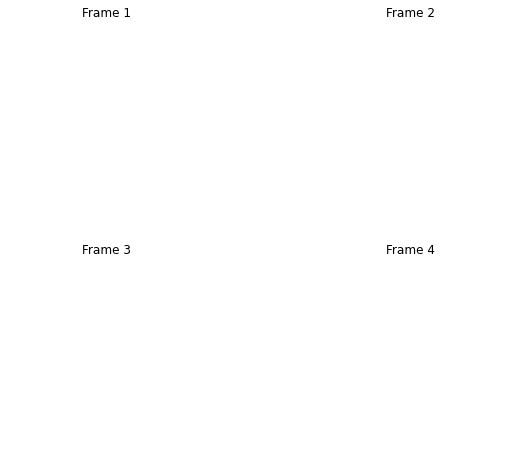

In [ ]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(X_data)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    new_img = X_data[data_choice][idx]
    ax.imshow(np.squeeze(new_img))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
from keras.models import Sequential, Model 

def get_model():
  model = Sequential()
  model.add(
      layers.ConvLSTM2D(
          filters = 64, 
          kernel_size = (3, 3), 
          return_sequences = False, 
          data_format = "channels_last", 
          input_shape = (4, 51, 51, 3)
      )
  )
  model.add(
      layers.Dropout(0.2)
  )
  model.add(
      layers.Flatten()
  )
  model.add(
      layers.Dense(256, activation="relu")
  )
  model.add(
      layers.Dropout(0.3)
  )
  model.add(
      layers.Dense(3, activation = "softmax")
  )
  
  return model  


In [ ]:
with strategy.scope():

  model = get_model()
  
  opt = keras.optimizers.Adam()

  early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

model.summary()

batch_size = 100
epochs = 50

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 49, 49, 64)        154624    
                                                                 
 dropout_8 (Dropout)         (None, 49, 49, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 153664)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               39338240  
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 39,493,635
Trainable params: 39,493,635


In [ ]:
callbacks = [early_stopping, reduce_lr]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
) 

Epoch 1/50
71/71 [==============================] - 40s 400ms/step - loss: 2.7465 - accuracy: 0.6531 - val_loss: 0.5858 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 11s 153ms/step - loss: 0.6750 - accuracy: 0.6842 - val_loss: 0.6165 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 11s 155ms/step - loss: 0.6521 - accuracy: 0.6825 - val_loss: 0.5671 - val_accuracy: 0.7474 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 11s 154ms/step - loss: 0.5755 - accuracy: 0.7519 - val_loss: 0.4668 - val_accuracy: 0.8106 - lr: 0.0010
Epoch 5/50
71/71 [==============================] - 11s 153ms/step - loss: 0.5213 - accuracy: 0.7829 - val_loss: 0.4333 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 6/50
71/71 [==============================] - 11s 153ms/step - loss: 0.5104 - accuracy: 0.7811 - val_loss: 0.3900 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 7/50
71/71 [==============================] - 11s 153ms/st

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

y_pred_ugly = y_pred.argmax(axis=1)
y_test_ugly = y_test.argmax(axis=1)

print(classification_report(y_test_ugly, y_pred_ugly))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       719
           1       0.87      0.83      0.85       746
           2       0.82      0.87      0.85       733

    accuracy                           0.88      2198
   macro avg       0.88      0.88      0.88      2198
weighted avg       0.88      0.88      0.88      2198



In [ ]:
with open('/content/drive/MyDrive/ConvLSTM/ConvLSTM_History', 'wb') as f:
        pickle.dump(history.history, f)
      
f.close()

In [ ]:
model.save_weights(os.path.join("/content/drive/MyDrive/ConvLSTM/", 'ConvLSTM.h5'), overwrite=True)

### Example of how to load the trained model

In [ ]:
# Create a basic model instance
model = get_model()
model.load_weights("/content/drive/MyDrive/TemporalData-Processed/ConvLSTM.h5")

View Training History

In [ ]:
history = pickle.load(open('/content/drive/MyDrive/ConvLSTM/ConvLSTM_History', "rb"))

In [ ]:
history_keys = list(history.keys())

loss = history_keys[0]
acc = history_keys[1]
val_loss = history_keys[2]
val_acc = history_keys[3] 

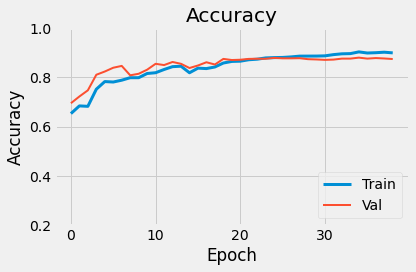

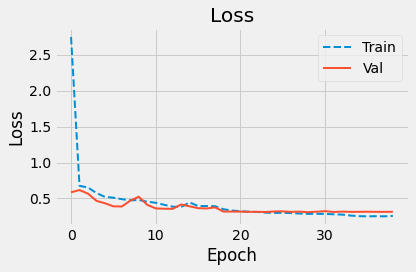

In [ ]:
plt.style.use('fivethirtyeight')
plt.plot(history[acc], linewidth=3)
plt.plot(history[val_acc], linewidth=2)
plt.ylim([0.2, 1])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ConvLSTM/AccFigure')
plt.show()


# summarize history for loss
plt.style.use('fivethirtyeight')
plt.plot(history[loss], linestyle='--', linewidth=2)
plt.plot(history[val_loss], linewidth=2)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ConvLSTM/LossFigure')
plt.show()